## Part : 01 Perform Web Scrapping by using Selenium to scrap 5 categorial Data into Csv

In [24]:
import csv
import time
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from webdriver_manager.chrome import ChromeDriverManager

# ---------------- CONFIG ----------------
MAIN_CATEGORIES = [
    "https://www.banggood.com/Wholesale-Phones-and-Accessories-ca-1001.html",
    "https://www.banggood.com/Wholesale-Electronics-ca-2001.html",
    "https://www.banggood.com/el/Wholesale-Sports-and-Outdoors-ca-6001.html",
    "https://www.banggood.com/el/Wholesale-Lights-and-Lighting-ca-14001.html",
    "https://www.banggood.com/el/Wholesale-Tools,Industrial-and-Scientific-ca-3001.html"
]

OUTPUT_CSV = "banggood_products.csv"
SCROLL_PAUSE = 2

# ---------------- SETUP DRIVER ----------------
options = webdriver.ChromeOptions()
# options.add_argument("--headless")  # Uncomment if you want headless mode
options.add_argument("--disable-gpu")
options.add_argument("--no-sandbox")
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)
wait = WebDriverWait(driver, 10)

# ---------------- HELPER FUNCTIONS ----------------
def scroll_to_bottom(driver, pause_time=2, max_scrolls=5):
    """Scroll page to load lazy products"""
    last_height = driver.execute_script("return document.body.scrollHeight")
    for _ in range(max_scrolls):
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(pause_time)
        new_height = driver.execute_script("return document.body.scrollHeight")
        if new_height == last_height:
            break
        last_height = new_height

def extract_products(driver, main_cat, sub_cat, sub_sub_cat=None):
    """Extract product info from current page"""
    products = []
    scroll_to_bottom(driver, pause_time=SCROLL_PAUSE, max_scrolls=5)
    
    product_selectors = [
        ".goods-box .goods-item", ".product-item", ".product-card", ".p-list .p-item"
    ]
    
    product_elements = []
    for sel in product_selectors:
        els = driver.find_elements(By.CSS_SELECTOR, sel)
        if els and len(els) > len(product_elements):
            product_elements = els
    
    for el in product_elements:
        try:
            title = el.find_element(By.CSS_SELECTOR, "a").get_attribute("title") or el.text
            url = el.find_element(By.CSS_SELECTOR, "a").get_attribute("href")
            try:
                price = el.find_element(By.CSS_SELECTOR, ".price").text
            except:
                price = ""
            try:
                rating = el.find_element(By.CSS_SELECTOR, ".star").text
            except:
                rating = ""
            
            products.append({
                "main_category": main_cat,
                "subcategory": sub_cat,
                "sub_subcategory": sub_sub_cat if sub_sub_cat else "",
                "title": title.strip(),
                "price": price.strip(),
                "rating": rating.strip(),
                "url": url
            })
        except:
            continue
    return products

def get_subcategory_links():
    """Get all valid subcategory/sub-subcategory links on current page"""
    links = []
    try:
        elements = driver.find_elements(By.CSS_SELECTOR, ".category-list a, .sub-category a")
        for e in elements:
            name = e.text.strip()
            url = e.get_attribute("href")
            if url and name:
                links.append((name, url))
    except:
        pass
    return links

def scrape_category(main_cat_url, main_cat_name):
    """Recursively scrape category → subcategory → sub-subcategory"""
    all_products = []

    driver.get(main_cat_url)
    time.sleep(3)
    
    sub_links = get_subcategory_links()
    if not sub_links:
        # no subcategories, extract products directly
        for page in range(1, MAX_PAGES + 1):
            page_url = f"{main_cat_url}?page={page}"
            driver.get(page_url)
            time.sleep(3)
            products = extract_products(driver, main_cat_name, main_cat_name)
            if not products:
                break
            all_products.extend(products)
        return all_products
    
    # iterate subcategories
    for sub_name, sub_url in sub_links[:5]:  # limit to 5 subcategories per main category
        driver.get(sub_url)
        time.sleep(3)
        sub_sub_links = get_subcategory_links()
        if sub_sub_links:
            # iterate sub-subcategories
            for sub_sub_name, sub_sub_url in sub_sub_links[:3]:  # limit to 3 sub-subcategories
                for page in range(1, MAX_PAGES + 1):
                    page_url = f"{sub_sub_url}?page={page}"
                    driver.get(page_url)
                    time.sleep(3)
                    products = extract_products(driver, main_cat_name, sub_name, sub_sub_name)
                    if not products:
                        break
                    all_products.extend(products)
        else:
            # no sub-subcategories, scrape products in subcategory
            for page in range(1, MAX_PAGES + 1):
                page_url = f"{sub_url}?page={page}"
                driver.get(page_url)
                time.sleep(3)
                products = extract_products(driver, main_cat_name, sub_name)
                if not products:
                    break
                all_products.extend(products)
    return all_products

# ---------------- MAIN SCRAPER ----------------
all_data = []
for cat_url in MAIN_CATEGORIES:
    print(f"Processing main category: {cat_url}")
    driver.get(cat_url)
    time.sleep(2)
    main_cat_name = driver.title.split(" | ")[0]  # approximate category name
    cat_products = scrape_category(cat_url, main_cat_name)
    print(f"  → Collected {len(cat_products)} products")
    all_data.extend(cat_products)

# ---------------- SAVE CSV ----------------
keys = ["main_category", "subcategory", "sub_subcategory", "title", "price", "rating", "url"]
with open(OUTPUT_CSV, "w", newline="", encoding="utf-8") as f:
    writer = csv.DictWriter(f, fieldnames=keys)
    writer.writeheader()
    writer.writerows(all_data)

print(f"Scraping complete! Saved {len(all_data)} products to {OUTPUT_CSV}")
driver.quit()

Processing main category: https://www.banggood.com/Wholesale-Phones-and-Accessories-ca-1001.html
  → Collected 180 products
Processing main category: https://www.banggood.com/Wholesale-Electronics-ca-2001.html
  → Collected 180 products
Processing main category: https://www.banggood.com/el/Wholesale-Sports-and-Outdoors-ca-6001.html
  → Collected 180 products
Processing main category: https://www.banggood.com/el/Wholesale-Lights-and-Lighting-ca-14001.html
  → Collected 180 products
Processing main category: https://www.banggood.com/el/Wholesale-Tools,Industrial-and-Scientific-ca-3001.html
  → Collected 180 products
Scraping complete! Saved 900 products to banggood_products.csv


## Part: 02 Data Clean Transform and Add Two dervied features

In [50]:
import pandas as pd

df = pd.read_csv("banggood_products.csv")


In [51]:
# Clean Price
def clean_price(x):
    if pd.isna(x):
        return np.nan
    return pd.to_numeric(str(x).replace("US$", "").strip(), errors="coerce")

df["price_usd"] = df["price"].apply(clean_price)

# Missing price handling
df["price_usd"].fillna(df["price_usd"].median(), inplace=True)

C:\Users\my pc\AppData\Local\Temp\ipykernel_11420\481669454.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["price_usd"].fillna(df["price_usd"].median(), inplace=True)


In [ ]:
# Handle Missing values
df["price_usd"].fillna(df["price_usd"].median(), inplace=True)

C:\Users\my pc\AppData\Local\Temp\ipykernel_11420\3634040261.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["price_usd"].fillna(df["price_usd"].median(), inplace=True)


In [ ]:
# DERIVED FEATURE 1
df["title_length"] = df["title"].apply(lambda x: len(str(x)))


In [57]:
def extract_brand(title):
    if pd.isna(title):
        return "Unknown"
    first_word = str(title).split()[0]
    return first_word.replace("[", "").replace("]", "")

df["brand_name"] = df["title"].apply(extract_brand)

In [ ]:
# Dervied Feature 2
def price_bucket(p):
    if p < 20:
        return "Low"
    elif p < 100:
        return "Medium"
    else:
        return "High"

df["price_category"] = df["price_usd"].apply(price_bucket)


In [59]:
df.to_csv("banggood_products_cleaned.csv", index=False)

print("Done — banggood_products_cleaned.csv saved successfully!")

Done — banggood_products_cleaned.csv saved successfully!


# Part : 03 Exploratory Data Analysis 5 Analysis

In [74]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load cleaned CSV
df = pd.read_csv("banggood_products_cleaned.csv")


In [75]:
sns.set(style="whitegrid")


C:\Users\my pc\AppData\Local\Temp\ipykernel_11420\2351905054.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='price_category', y='price_usd', data=df, palette='Set2')


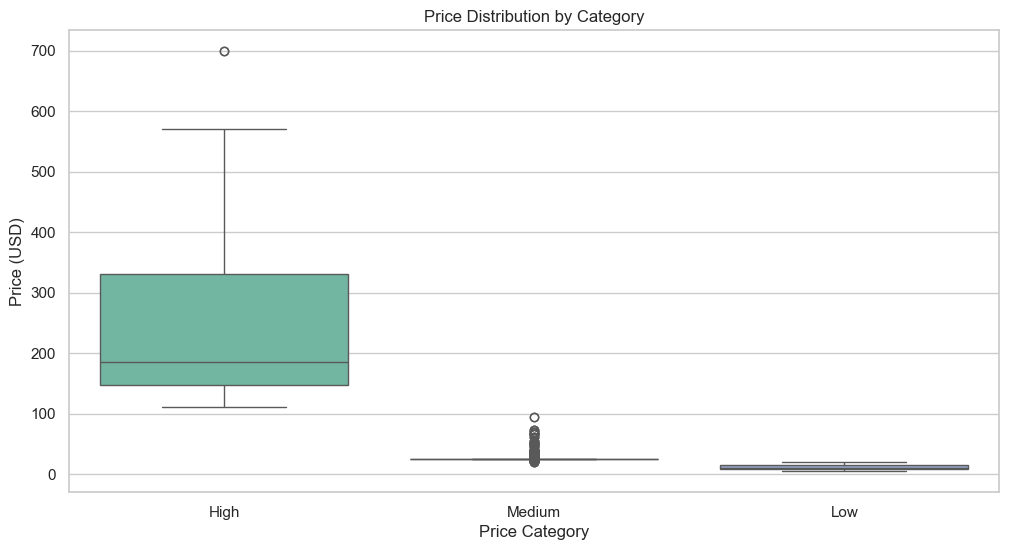

In [76]:
# Price Distribution by Category
plt.figure(figsize=(12,6))
sns.boxplot(x='price_category', y='price_usd', data=df, palette='Set2')
plt.title("Price Distribution by Category")
plt.xlabel("Price Category")
plt.ylabel("Price (USD)")
plt.show()

C:\Users\my pc\AppData\Local\Temp\ipykernel_11420\1671575180.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='price_category', data=df, order=df['price_category'].value_counts().index, palette='viridis')


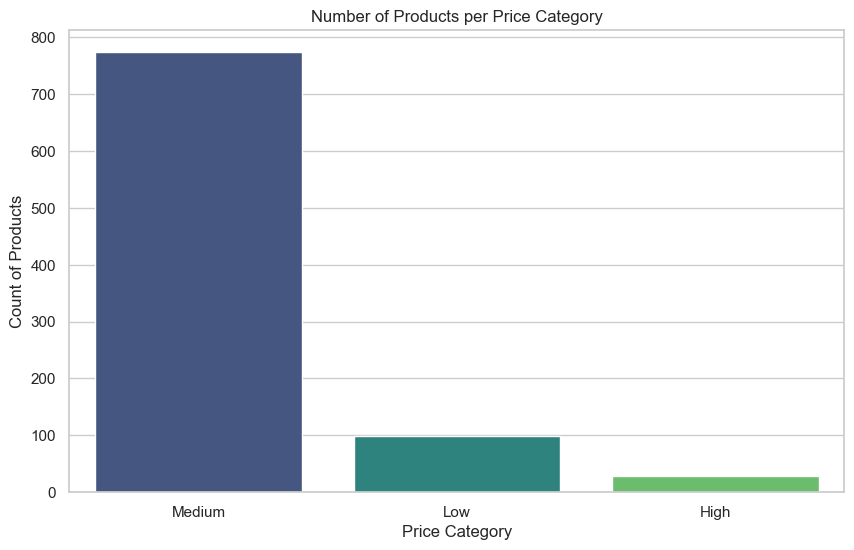

In [ ]:
# Count of Products per Price Category
plt.figure(figsize=(10,6))
sns.countplot(x='price_category', data=df, order=df['price_category'].value_counts().index, palette='viridis')
plt.title("Number of Products per Price Category")
plt.xlabel("Price Category")
plt.ylabel("Count of Products")
plt.show()

C:\Users\my pc\AppData\Local\Temp\ipykernel_11420\2098270581.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='price_usd', y='title', data=top_expensive, palette='magma')
C:\Users\my pc\AppData\Local\Temp\ipykernel_11420\2098270581.py:7: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


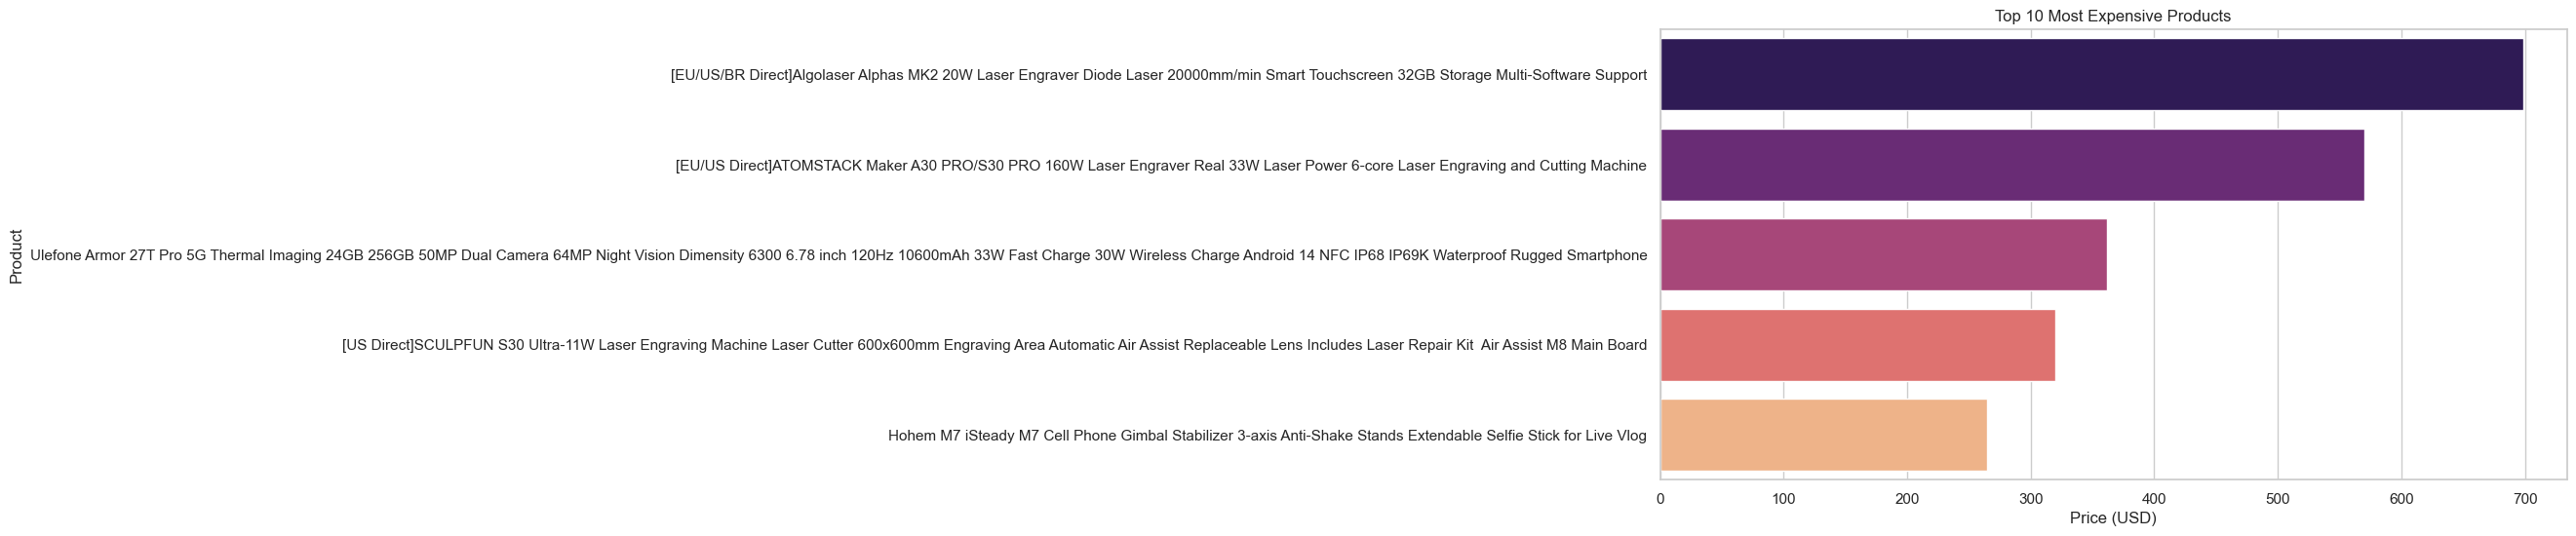

In [ ]:
#  Top 10 Most Expensive Products
top_expensive = df.sort_values(by='price_usd', ascending=False).head(10)
plt.figure(figsize=(12,6))
sns.barplot(x='price_usd', y='title', data=top_expensive, palette='magma')
plt.title("Top 10 Most Expensive Products")
plt.xlabel("Price (USD)")
plt.ylabel("Product")
plt.tight_layout()
plt.show()

C:\Users\my pc\AppData\Local\Temp\ipykernel_11420\452441514.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='main_category', data=df, order=df['main_category'].value_counts().index, palette='coolwarm')


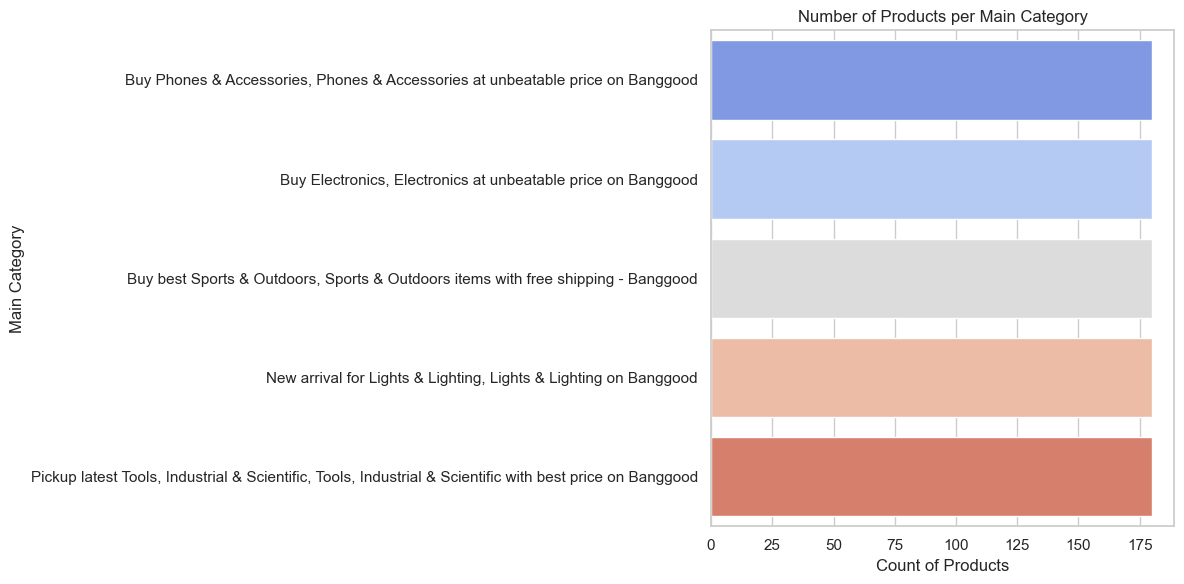

In [ ]:
# Count of Products per Main Category
plt.figure(figsize=(12,6))
sns.countplot(y='main_category', data=df, order=df['main_category'].value_counts().index, palette='coolwarm')
plt.title("Number of Products per Main Category")
plt.xlabel("Count of Products")
plt.ylabel("Main Category")
plt.tight_layout()
plt.show()


C:\Users\my pc\AppData\Local\Temp\ipykernel_11420\1655353979.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='price_usd', y='main_category', data=avg_price, palette='cubehelix')


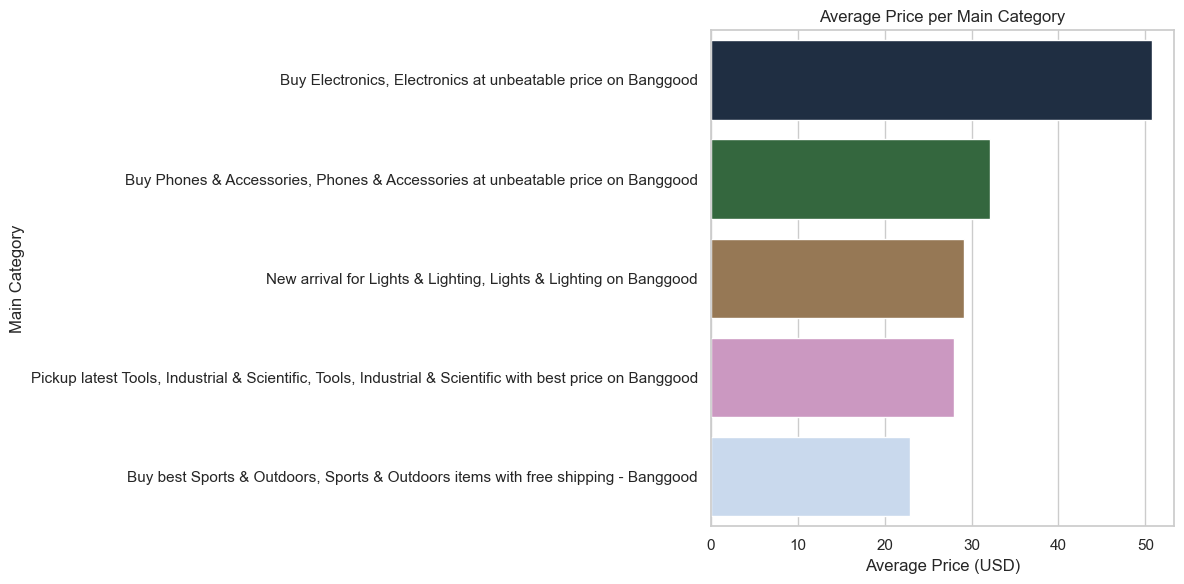

In [ ]:
# Average Price per Main Category
avg_price = df.groupby('main_category')['price_usd'].mean().reset_index().sort_values(by='price_usd', ascending=False)
plt.figure(figsize=(12,6))
sns.barplot(x='price_usd', y='main_category', data=avg_price, palette='cubehelix')
plt.title("Average Price per Main Category")
plt.xlabel("Average Price (USD)")
plt.ylabel("Main Category")
plt.tight_layout()
plt.show()

## Part : 04 Load Data into SQL SERVER

In [ ]:
!pip install pyodbc


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [87]:
import pandas as pd
import pyodbc

# Load cleaned CSV
df = pd.read_csv("banggood_products_cleaned.csv")

# Ensure numeric columns are numeric
df['price_usd'] = pd.to_numeric(df['price_usd'], errors='coerce')


In [91]:
import pyodbc

server = r'DESKTOP-34R9A31\SQL2025Z'
database = 'BanggoodDB'

conn = pyodbc.connect(
    f'DRIVER={{ODBC Driver 18 for SQL Server}};'
    f'SERVER={server};'
    f'DATABASE={database};'
    f'Trusted_Connection=yes;'
    f'Encrypt=no;'  # SSL disable
)
cursor = conn.cursor()
print("Connection successful!")


Connection successful!


In [94]:
print(df.columns.tolist())


['main_category', 'subcategory', 'sub_subcategory', 'title', 'price', 'rating', 'url', 'price_usd', 'title_length', 'brand_name', 'price_category']


In [95]:
# Example: agar original name 'review count' hai
numeric_cols = ['price', 'rating', 'review count', 'popularity_score', 'value_score', 'price_performance']

for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
        df[col] = df[col].fillna(0)


In [96]:
text_cols = ['main_category', 'subcategory', 'sub_subcategory', 'title', 'url', 'price_category']
for col in text_cols:
    if col in df.columns:
        df[col] = df[col].astype(str)


In [98]:
df.columns = df.columns.str.strip()
print(df.columns.tolist())  # confirm column names

['main_category', 'subcategory', 'sub_subcategory', 'title', 'price', 'rating', 'url', 'price_usd', 'title_length', 'brand_name', 'price_category']


In [99]:
numeric_cols = ['price', 'rating', 'review_count', 'popularity_score', 'value_score', 'price_performance']

for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
        df[col] = df[col].fillna(0)


In [100]:
text_cols = ['main_category', 'subcategory', 'sub_subcategory', 'title', 'url', 'price_category']

for col in text_cols:
    if col in df.columns:
        df[col] = df[col].astype(str)


In [101]:
insert_query = """
INSERT INTO dbo.BanggoodProducts
(main_category, subcategory, sub_subcategory, title, price, rating, review_count, url, price_category, popularity_score, value_score, price_performance)
VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
"""

for index, row in df.iterrows():
    cursor.execute(insert_query, 
                   row.get('main_category', ''),
                   row.get('subcategory', ''),
                   row.get('sub_subcategory', ''),
                   row.get('title', ''),
                   float(row.get('price', 0)),
                   float(row.get('rating', 0)),
                   float(row.get('review_count', 0)),
                   row.get('url', ''),
                   row.get('price_category', ''),
                   float(row.get('popularity_score', 0)),
                   float(row.get('value_score', 0)),
                   float(row.get('price_performance', 0))
                  )
conn.commit()
print(f"{len(df)} rows inserted successfully!")


900 rows inserted successfully!


In [104]:
import pyodbc
import pandas as pd

server = r'DESKTOP-34R9A31\SQL2025Z'
database = 'BanggoodDB'

conn = pyodbc.connect(
    f'DRIVER={{ODBC Driver 18 for SQL Server}};'
    f'SERVER={server};'
    f'DATABASE={database};'
    f'Trusted_Connection=yes;'
    f'Encrypt=no;'   # <-- yaha encryption disable kar di
)
cursor = conn.cursor()

# Test query
df_sql = pd.read_sql("SELECT TOP 10 * FROM dbo.BanggoodProducts", conn)
print(df_sql.head())


   id                                      main_category  \
0   1  Buy Phones & Accessories, Phones & Accessories...   
1   2  Buy Phones & Accessories, Phones & Accessories...   
2   3  Buy Phones & Accessories, Phones & Accessories...   
3   4  Buy Phones & Accessories, Phones & Accessories...   
4   5  Buy Phones & Accessories, Phones & Accessories...   

                                         subcategory sub_subcategory  \
0  Buy Phones & Accessories, Phones & Accessories...             nan   
1  Buy Phones & Accessories, Phones & Accessories...             nan   
2  Buy Phones & Accessories, Phones & Accessories...             nan   
3  Buy Phones & Accessories, Phones & Accessories...             nan   
4  Buy Phones & Accessories, Phones & Accessories...             nan   

                                               title  price  rating  \
0  Ulefone Armor 27T Pro 5G Thermal Imaging 24GB ...    0.0     0.0   
1  [GaN Tech] Blitzwolf® BW-S31 240W 6-Port USB P...    0.0     

C:\Users\my pc\AppData\Local\Temp\ipykernel_11420\3629206.py:17: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_sql = pd.read_sql("SELECT TOP 10 * FROM dbo.BanggoodProducts", conn)


In [92]:
df = pd.read_csv('banggood_products_cleaned.csv')

# 3. Create table (adjust columns according to CSV)
create_table_query = """
IF OBJECT_ID('dbo.BanggoodProducts', 'U') IS NOT NULL
    DROP TABLE dbo.BanggoodProducts;

CREATE TABLE dbo.BanggoodProducts (
    id INT IDENTITY(1,1) PRIMARY KEY,
    main_category NVARCHAR(255),
    subcategory NVARCHAR(255),
    sub_subcategory NVARCHAR(255),
    title NVARCHAR(MAX),
    price FLOAT,
    rating FLOAT,
    review_count INT,
    url NVARCHAR(MAX),
    price_category NVARCHAR(50),
    popularity_score FLOAT,
    value_score FLOAT,
    price_performance FLOAT
)
"""
cursor.execute(create_table_query)
conn.commit()
print("Table created successfully!")

# 4. Insert data into SQL Server
insert_query = """
INSERT INTO dbo.BanggoodProducts
(main_category, subcategory, sub_subcategory, title, price, rating, review_count, url, price_category, popularity_score, value_score, price_performance)
VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
"""

for index, row in df.iterrows():
    cursor.execute(insert_query, 
                   row.get('main_category'),
                   row.get('subcategory'),
                   row.get('sub_subcategory'),
                   row.get('title'),
                   row.get('price'),
                   row.get('rating'),
                   row.get('review_count'),
                   row.get('url'),
                   row.get('price_category'),
                   row.get('popularity_score'),
                   row.get('value_score'),
                   row.get('price_performance')
                  )
conn.commit()
print(f"{len(df)} rows inserted successfully!")

# 5. Validate row count
cursor.execute("SELECT COUNT(*) FROM dbo.BanggoodProducts")
count = cursor.fetchone()[0]
print(f"Total rows in SQL Server table: {count}")

# Close connection
cursor.close()
conn.close()

Table created successfully!


ProgrammingError: ('42000', '[42000] [Microsoft][ODBC Driver 18 for SQL Server][SQL Server]The incoming tabular data stream (TDS) remote procedure call (RPC) protocol stream is incorrect. Parameter 6 (""): The supplied value is not a valid instance of data type float. Check the source data for invalid values. An example of an invalid value is data of numeric type with scale greater than precision. (8023) (SQLExecDirectW)')